In [1]:
import findspark
findspark.init('/afs/cern.ch/work/m/migliori/public/spark-2.4/')

In [2]:
application_name = 'hyperparameter-search'
master = "local[16]"
driver_memory = '64G'

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .appName(application_name)\
        .config("spark.pyspark.python",
                "/afs/cern.ch/work/m/migliori/public/anaconda2/bin/python")\
        .config("spark.master", master)\
        .config("spark.driver.memory", driver_memory)\
        .config("spark.driver.maxResultSize", "64G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")\
        .getOrCreate()

In [4]:
spark

## Load train and test datasets

In [6]:
from __future__ import print_function

In [7]:
%%time
trainDF = spark.read.format('parquet')\
        .load('hdfs://hadalytic/project/ML/data/train100k.parquet')\
        .select(['HLF_input', 'encoded_label'])
        
testDF = spark.read.format('parquet')\
        .load('hdfs://hadalytic/project/ML/data/test20k.parquet')\
        .select(['HLF_input', 'encoded_label'])
        
test_events = testDF.count()
train_events = trainDF.count()
print('There are', train_events, 'training events')
print('There are', test_events, 'test events')

There are 99656 training events
There are 20173 test events
CPU times: user 5.91 ms, sys: 8.22 ms, total: 14.1 ms
Wall time: 26.4 s


Now we can convert the Spark dataframes to Pandas

In [8]:
import numpy as np

In [9]:
trainDF = trainDF.toPandas()
testDF = testDF.toPandas()

In [10]:
trainDF.head()

,HLF_input,encoded_label
0,"[0.0, 0.004093188025030354, 0.6636617564181393...","(0.0, 0.0, 1.0)"
1,"[0.006637775825149609, 0.04995229218498003, 0....","(1.0, 0.0, 0.0)"
2,"[0.007647997639186321, 0.02028482486460716, 0....","(0.0, 0.0, 1.0)"
3,"[0.05113739451279049, 0.040669991536800086, 0....","(0.0, 1.0, 0.0)"
4,"[0.0, 0.02776366095244539, 0.16691218668213223...","(1.0, 0.0, 0.0)"


Convert `Dense` and `Sparse` vectors to list

In [11]:
trainDF[trainDF.columns] = trainDF[trainDF.columns].applymap(lambda x: list(x))
testDF[testDF.columns] = testDF[testDF.columns].applymap(lambda x: list(x))

In [12]:
X = np.array(trainDF['HLF_input'].tolist())
y = np.array(trainDF['encoded_label'].tolist())

In [45]:
X_test = np.array(testDF['HLF_input'].tolist())
y_test = np.array(testDF['encoded_label'].tolist())

## Create the keras model

In [13]:
from keras.optimizers import adam
from keras.models import Sequential
from keras.layers.core import Dense, Activation

def create_model(nh_1, nh_2, nh_3):
    ## Create model
    model = Sequential()
    model.add(Dense(nh_1, input_shape=(14,), activation='relu'))
    model.add(Dense(nh_2, activation='relu'))
    model.add(Dense(nh_3, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    ## Compile model
    optimizer = 'adam'
    loss = 'categorical_crossentropy'
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    
    return model

Using TensorFlow backend.


## Baseline model

In [63]:
baseline = create_model(50,20,10)

%time history = baseline.fit(X, y, batch_size=100, epochs=50, validation_data=(X_test,y_test),verbose=0)

CPU times: user 2min 23s, sys: 33.3 s, total: 2min 56s
Wall time: 1min 4s


In [64]:
import matplotlib.pyplot as plt 
%matplotlib notebook

<IPython.core.display.Javascript object>


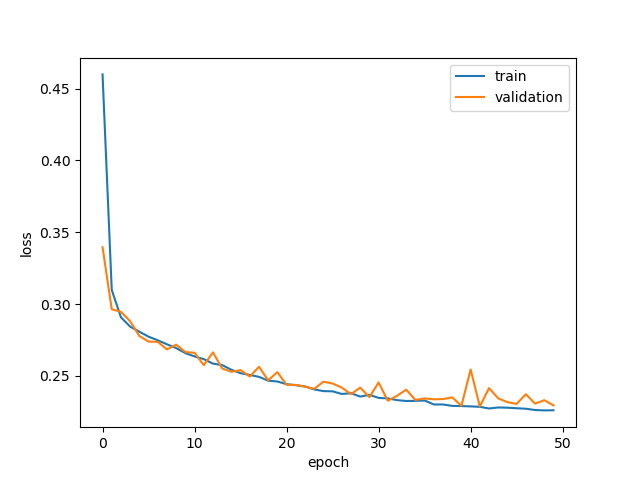

In [67]:
%matplotlib notebook
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

<IPython.core.display.Javascript object>


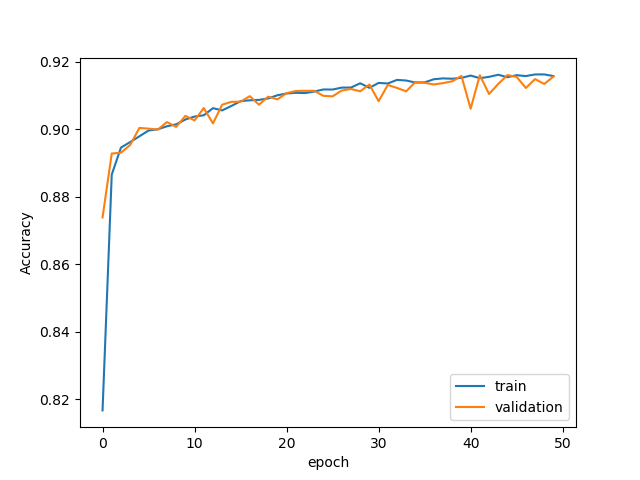

In [66]:
%matplotlib notebook
plt.figure()
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

In [71]:
y_pred = baseline.predict(X_test)

In [73]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<IPython.core.display.Javascript object>


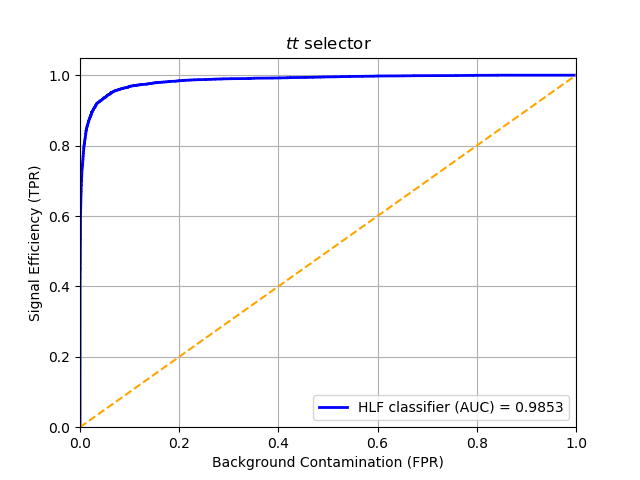

In [74]:
%matplotlib notebook

plt.figure()
plt.plot(fpr[1], tpr[1], color='blue', 
         lw=2, label='HLF classifier (AUC) = %0.4f' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Create the keras classifier

In [14]:
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, verbose=0)

## Define the grid search parameters

In [15]:
batch_size = [100,200]
epochs = [5,10]

## Number of hidden units per layer
nh_1 = [50]
nh_2 = [20]
nh_3 = [10]

In [16]:
param_grid = {'batch_size':batch_size,
              'epochs':epochs,
              'nh_1':nh_1, 'nh_2':nh_2, 'nh_3':nh_3}

## Grid search

In [83]:
from sklearn.grid_search import GridSearchCV

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=5)

In [84]:
%time grid_results = grid.fit(X,y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] epochs=5, nh_3=10, nh_1=50, batch_size=100, nh_2=20 .............
[CV]  epochs=5, nh_3=10, nh_1=50, batch_size=100, nh_2=20, score=0.890605 -   5.3s
[CV] epochs=5, nh_3=10, nh_1=50, batch_size=100, nh_2=20 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV]  epochs=5, nh_3=10, nh_1=50, batch_size=100, nh_2=20, score=0.893043 -   5.6s
[CV] epochs=5, nh_3=10, nh_1=50, batch_size=100, nh_2=20 .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s


[CV]  epochs=5, nh_3=10, nh_1=50, batch_size=100, nh_2=20, score=0.891475 -   5.4s
[CV] epochs=10, nh_3=10, nh_1=50, batch_size=100, nh_2=20 ............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.4s remaining:    0.0s


[CV]  epochs=10, nh_3=10, nh_1=50, batch_size=100, nh_2=20, score=0.898943 -   9.8s
[CV] epochs=10, nh_3=10, nh_1=50, batch_size=100, nh_2=20 ............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   26.2s remaining:    0.0s


[CV]  epochs=10, nh_3=10, nh_1=50, batch_size=100, nh_2=20, score=0.902044 -  10.1s
[CV] epochs=10, nh_3=10, nh_1=50, batch_size=100, nh_2=20 ............
[CV]  epochs=10, nh_3=10, nh_1=50, batch_size=100, nh_2=20, score=0.895207 -  10.6s
[CV] epochs=5, nh_3=10, nh_1=50, batch_size=200, nh_2=20 .............
[CV]  epochs=5, nh_3=10, nh_1=50, batch_size=200, nh_2=20, score=0.888467 -   3.8s
[CV] epochs=5, nh_3=10, nh_1=50, batch_size=200, nh_2=20 .............
[CV]  epochs=5, nh_3=10, nh_1=50, batch_size=200, nh_2=20, score=0.887324 -   3.9s
[CV] epochs=5, nh_3=10, nh_1=50, batch_size=200, nh_2=20 .............
[CV]  epochs=5, nh_3=10, nh_1=50, batch_size=200, nh_2=20, score=0.892317 -   4.0s
[CV] epochs=10, nh_3=10, nh_1=50, batch_size=200, nh_2=20 ............
[CV]  epochs=10, nh_3=10, nh_1=50, batch_size=200, nh_2=20, score=0.896565 -   6.6s
[CV] epochs=10, nh_3=10, nh_1=50, batch_size=200, nh_2=20 ............
[CV]  epochs=10, nh_3=10, nh_1=50, batch_size=200, nh_2=20, score=0.89560

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.3min finished


CPU times: user 3min 5s, sys: 35.6 s, total: 3min 41s
Wall time: 1min 34s


Let's try to add more parallel workers

In [86]:
grid_results.best_estimator_.get_params()

{'batch_size': 100,
 'build_fn': <function __main__.create_model>,
 'epochs': 10,
 'nh_1': 50,
 'nh_2': 20,
 'nh_3': 10,
 'verbose': 0}

## Grid Search with Spark

In [79]:
from spark_sklearn.grid_search import GridSearchCV

sc = spark.sparkContext

grid = GridSearchCV(sc, estimator=model, param_grid=param_grid, cv=3, verbose=5)

In [80]:
%time grid_results = grid.fit(X,y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
CPU times: user 28.7 s, sys: 6.26 s, total: 34.9 s
Wall time: 22.2 s


In [81]:
grid_results.best_estimator_.get_params()

{'batch_size': 100,
 'build_fn': <function __main__.create_model>,
 'epochs': 10,
 'nh_1': 50,
 'nh_2': 20,
 'nh_3': 10,
 'verbose': 0}